In [235]:
# load data
import glob
import os

# computing
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# feature extraction
import cv2
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer # https://realpython.com/k-means-clustering-python/

# modelling
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# evalutaion
from sklearn.metrics import classification_report

# load/save model
import pickle

# Load Data

- input: -
- output: `X_train, y_train, X_test, y_test`

In [132]:
# ukurang gambar 224x224
def import_image(file) :
    image = cv2.imread(file)
    return image

def label_image(character, length) :
    array = np.full(length, character)
    return array

def import_data(character, path) :
    file_path = glob.glob(path)
    images = np.array([import_image(file) for file in file_path])
    label = label_image(character, len(file_path))
    
    return images, label

In [133]:
hanacaraka = ('ba','ca','da','dha','ga','ha','ja','ka','la','ma','na','nga','nya','pa','ra','sa','ta','tha','wa','ya')

X_train = np.empty((0, 224, 224, 3), np.uint8)
y_train = np.empty((0))
X_test = np.empty((0, 224, 224, 3), np.uint8)
y_test = np.empty((0))

for character in hanacaraka:
    training_path = "../Dataset/train/" + character + "/*.png"
    testing_path = "../Dataset/val/" + character + "/*.png"
    
    temp_X_train, temp_y_train = import_data(character, training_path)
    temp_X_test, temp_y_test = import_data(character, testing_path)
    
    print("Ukuran karakter", character, "training:", temp_X_train.shape[0], "testing:", temp_X_test.shape[0])
    
    X_train = np.append(X_train, temp_X_train, axis=0)
    y_train = np.append(y_train, temp_y_train, axis=0)
    X_test = np.append(X_test, temp_X_test, axis=0)
    y_test = np.append(y_test, temp_y_test, axis=0)


Ukuran karakter ba training: 114 testing: 24
Ukuran karakter ca training: 108 testing: 24
Ukuran karakter da training: 108 testing: 24
Ukuran karakter dha training: 108 testing: 24
Ukuran karakter ga training: 108 testing: 24
Ukuran karakter ha training: 102 testing: 24
Ukuran karakter ja training: 108 testing: 24
Ukuran karakter ka training: 108 testing: 24
Ukuran karakter la training: 108 testing: 24
Ukuran karakter ma training: 108 testing: 24
Ukuran karakter na training: 108 testing: 24
Ukuran karakter nga training: 102 testing: 24
Ukuran karakter nya training: 108 testing: 24
Ukuran karakter pa training: 108 testing: 24
Ukuran karakter ra training: 108 testing: 24
Ukuran karakter sa training: 108 testing: 24
Ukuran karakter ta training: 108 testing: 24
Ukuran karakter tha training: 108 testing: 24
Ukuran karakter wa training: 108 testing: 24
Ukuran karakter ya training: 108 testing: 24


In [134]:
# Ukuran keseluruhan data
print("Training:", X_train.shape[0])
print("Testing:", X_test.shape[0])

Training: 2154
Testing: 480


<AxesSubplot:ylabel='count'>

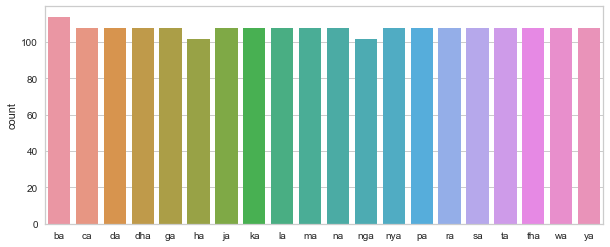

In [135]:
plt.figure(figsize=(10,4))
sns.countplot(x=y_train)

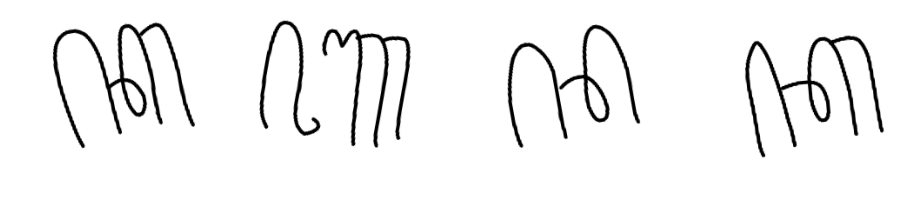

In [136]:
np.random.seed(42)

fig = plt.figure(figsize=(16, 4))
columns = 4
rows = 1
for i in range(1, columns*rows + 1):
    img = np.array(X_train[np.random.randint(0, 2154), 0:])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis('off')

plt.show()

# Preprocessing

- input: `X_train, X_test`
- output: `X_train_prep, X_test_prep`

kind of image preprocessing
- grayscaling (o)
- resizing (x)
- cropping (x)
- binarization (o)
- negative (x)
- skeletonization/thinning (o)
- noise reduction (x)
- sharpening (o)

In [167]:
def grayscaling(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return image
    
def thresholding(image):
    ret, image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    return image

def resizing(image, size=128):
    image = cv2.resize(image, (size, size), interpolation = cv2.INTER_AREA)
    return image

# https://soumyapatilblogs.medium.com/image-filtering-using-opencv-66b67e1bd968
def denoising(image):
    #image = cv2.fastNlMeansDenoisingColored(img, None, 5, 5, 7, 21)
    image = cv2.medianBlur(image, 5)
    return image

def sharpening(image):
    kernel = np.array([[0, -1, 0], [-1, 5,-1], [0, -1, 0]])
    #kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
    image = cv2.filter2D(src=image, ddepth=-1, kernel=kernel)
    return image

def preprocessing(image, size=128):
    image = resizing(image)
    return image

In [168]:
X_train_prep = []
X_test_prep = []

for i in range(X_train.shape[0]) :
    X_train_prep.append(preprocessing(X_train[i]))
    
for i in range(X_test.shape[0]) :
    X_test_prep.append(preprocessing(X_test[i]))
    
X_train_prep = np.array(X_train_prep, dtype=np.uint8)
X_test_prep = np.array(X_test_prep, dtype=np.uint8)

In [169]:
print("Dimensi data training:", X_train_prep.shape)
print("Dimensi data testing:", X_test_prep.shape)

Dimensi data training: (2154, 128, 128, 3)
Dimensi data testing: (480, 128, 128, 3)


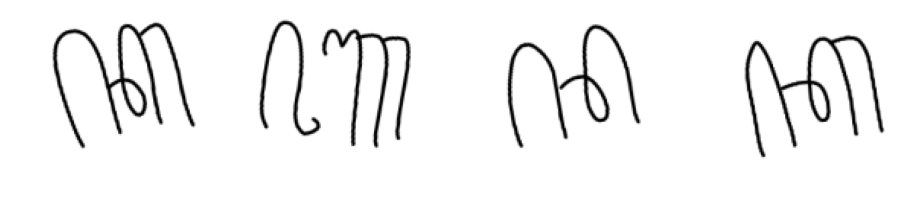

In [170]:
np.random.seed(42)

fig = plt.figure(figsize=(16, 4))
columns = 4
rows = 1
for i in range(1, columns*rows + 1):
    img = np.array(X_train_prep[np.random.randint(0, 2154), 0:])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis('off')

plt.show()

# Feature Extraction

- input: `X_train_prep, X_test_prep`
- output: `X_train_feature, X_test_feature`

### Extract sift descriptors 

In [171]:
def extract_sift_features(list_image):

    image_descriptors = []
    sift = cv2.SIFT_create()
    for image in list_image:
        _, descriptor = sift.detectAndCompute(image, None)
        image_descriptors.append(descriptor)

    return image_descriptors

def split_all_descriptors(image_descriptors):
    all_descriptors = []
    for descriptor in image_descriptors:
        if descriptor is not None:
            for des in descriptor:
                all_descriptors.append(des)
    
    return np.array(all_descriptors)

In [172]:
image_descriptors = extract_sift_features(X_train_prep)
all_descriptors = split_all_descriptors(image_descriptors)

In [173]:
all_descriptors.shape

(55881, 128)

<AxesSubplot:>

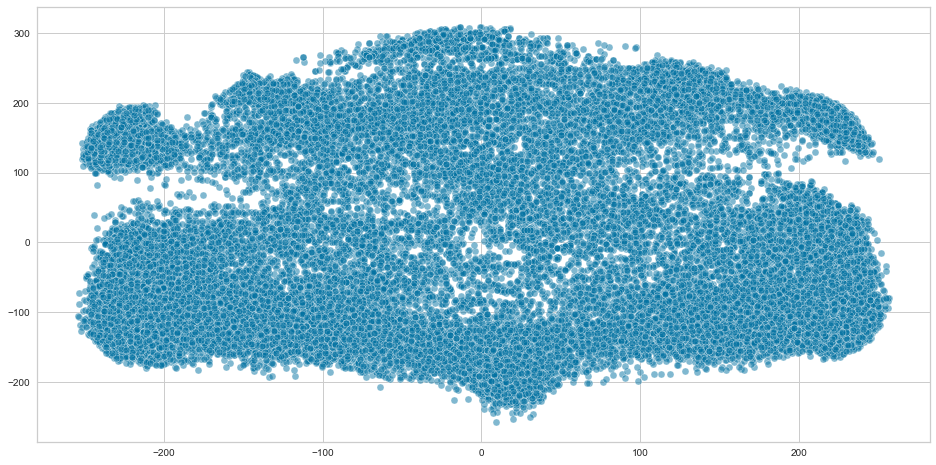

In [174]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(all_descriptors)

plt.figure(figsize=(16,8))
sns.scatterplot(x=X_pca.T[0], y=X_pca.T[1], alpha=0.5)

### Create bow of descriptor using cluster

In [236]:
ks = [50, 80, 120, 150, 200]
sse = []
silhouette_coefficients = []

for k in ks:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(all_descriptors)     
    sse.append(kmeans.inertia_)
    score = silhouette_score(all_descriptors, kmeans.labels_)
    silhouette_coefficients.append(score)

Text(0, 0.5, 'Silhouette Coefficient')

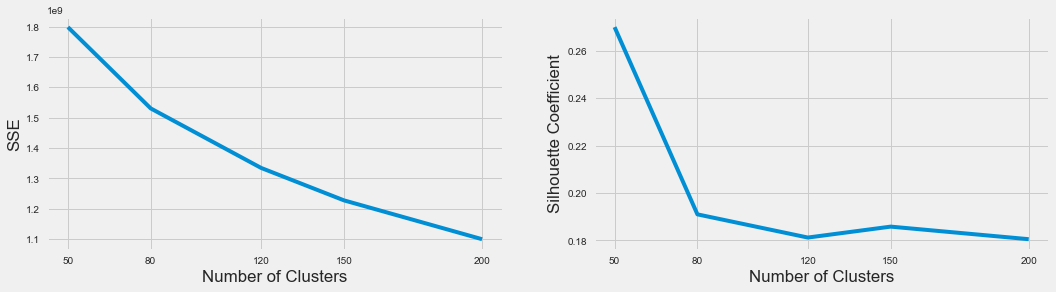

In [237]:
fig = plt.figure(figsize=(16, 4))
plt.style.use("fivethirtyeight")

fig.add_subplot(1, 2, 1)
plt.plot(ks, sse)
plt.xticks(ks)
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")

fig.add_subplot(1, 2, 2)
plt.plot(ks, silhouette_coefficients)
plt.xticks(ks)
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")

In [238]:
def kmeans_bow(all_descriptors, num_cluster):
    kmeans = KMeans(n_clusters = num_cluster)
    kmeans.fit(all_descriptors)

    bow_dict = kmeans.cluster_centers_

    #if not os.path.isfile('bow_dictionary.pkl'):
    pickle.dump(bow_dict, open('bow_dictionary.pkl', 'wb'))

    return kmeans, bow_dict

In [239]:
num_cluster = 120
kmeans, bow = kmeans_bow(all_descriptors, num_cluster)

### Create features from bow

In [240]:
def create_feature_bow(image_descriptors, bow, num_cluster):
    X_features = []

    for i in range(len(image_descriptors)):
        features = np.array([0] * num_cluster, dtype=float)

        if image_descriptors[i] is not None:
            distance = cdist(image_descriptors[i], bow)
            argmin = np.argmin(distance, axis = 1)

            for j in argmin:
                features[j] += 1.0
        X_features.append(features)

    return np.array(X_features)

In [241]:
X_train_feature = create_feature_bow(image_descriptors, bow, num_cluster)
X_test_feature = create_feature_bow(extract_sift_features(X_test_prep), bow, num_cluster)

print("Dimensi data training:", X_train_feature.shape)
print("Dimensi data testing:", X_test_feature.shape)

Dimensi data training: (2154, 120)
Dimensi data testing: (480, 120)


# Classification

- input: `X_train_feature, y_train, X_test_feature, y_test`
- output: -

In [242]:
# normalization
scaler = StandardScaler().fit(X_train_feature)
X_train_scale = scaler.transform(X_train_feature)
X_test_scale = scaler.transform(X_test_feature)

## KNN

In [243]:
knn_params = {'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]}
knn_cv = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=knn_params, cv=5, verbose=3)

In [244]:
knn_cv.fit(X_train_scale, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END .....................n_neighbors=1;, score=0.548 total time=   0.0s
[CV 2/5] END .....................n_neighbors=1;, score=0.490 total time=   0.0s
[CV 3/5] END .....................n_neighbors=1;, score=0.529 total time=   0.0s
[CV 4/5] END .....................n_neighbors=1;, score=0.568 total time=   0.0s
[CV 5/5] END .....................n_neighbors=1;, score=0.519 total time=   0.0s
[CV 1/5] END .....................n_neighbors=3;, score=0.573 total time=   0.0s
[CV 2/5] END .....................n_neighbors=3;, score=0.448 total time=   0.0s
[CV 3/5] END .....................n_neighbors=3;, score=0.510 total time=   0.0s
[CV 4/5] END .....................n_neighbors=3;, score=0.541 total time=   0.0s
[CV 5/5] END .....................n_neighbors=3;, score=0.530 total time=   0.0s
[CV 1/5] END .....................n_neighbors=5;, score=0.536 total time=   0.0s
[CV 2/5] END .....................n_neighbors=5;

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]},
             verbose=3)

In [245]:
print("Model terbaik:", knn_cv.best_estimator_)
print("Score terbaik:", knn_cv.best_score_)

Model terbaik: KNeighborsClassifier(n_neighbors=1)
Score terbaik: 0.5306350833648087


In [246]:
cv_results_df = pd.DataFrame(knn_cv.cv_results_)
cv_results_df = cv_results_df.sort_values(by=['rank_test_score'])
cv_results_df = (
    cv_results_df
    .set_index(cv_results_df["params"].apply(
        lambda x: "_".join(str(val) for val in x.values()))
    )
    .rename_axis('kernel')
)
cv_results_df[
    ['params', 'rank_test_score', 'mean_test_score', 'std_test_score']
]

,params,rank_test_score,mean_test_score,std_test_score
kernel,,,,
1,{'n_neighbors': 1},1,0.530635,0.026649
3,{'n_neighbors': 3},2,0.520432,0.041596
5,{'n_neighbors': 5},3,0.499539,0.037953
7,{'n_neighbors': 7},4,0.480509,0.049753
9,{'n_neighbors': 9},5,0.460079,0.035802
11,{'n_neighbors': 11},6,0.455912,0.042577
13,{'n_neighbors': 13},7,0.439661,0.041831
15,{'n_neighbors': 15},8,0.430836,0.045216
17,{'n_neighbors': 17},9,0.425729,0.040917


In [247]:
y_pred = knn_cv.predict(X_test_scale)

In [248]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          ba       0.42      0.21      0.28        24
          ca       0.83      0.21      0.33        24
          da       0.75      0.75      0.75        24
         dha       0.56      0.58      0.57        24
          ga       0.50      0.50      0.50        24
          ha       0.50      0.21      0.29        24
          ja       0.50      0.42      0.45        24
          ka       0.85      0.46      0.59        24
          la       0.45      0.21      0.29        24
          ma       1.00      0.58      0.74        24
          na       0.57      0.54      0.55        24
         nga       0.49      0.71      0.58        24
         nya       1.00      0.17      0.29        24
          pa       0.19      0.83      0.30        24
          ra       0.35      0.58      0.44        24
          sa       0.50      0.58      0.54        24
          ta       0.62      0.33      0.43        24
         tha       0.92    

### SVM

In [249]:
svm_params = {
    'C': [0.5, 1, 3, 6, 10],
    'gamma': ['scale', 'auto', 0.001, 0.003, 0.006]
}
svm_cv = GridSearchCV(estimator=SVC(kernel='rbf'), param_grid=svm_params, cv=5, verbose=3)

In [250]:
svm_cv.fit(X_train_scale, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ................C=0.5, gamma=scale;, score=0.747 total time=   0.3s
[CV 2/5] END ................C=0.5, gamma=scale;, score=0.740 total time=   0.3s
[CV 3/5] END ................C=0.5, gamma=scale;, score=0.735 total time=   0.3s
[CV 4/5] END ................C=0.5, gamma=scale;, score=0.761 total time=   0.3s
[CV 5/5] END ................C=0.5, gamma=scale;, score=0.807 total time=   0.3s
[CV 1/5] END .................C=0.5, gamma=auto;, score=0.747 total time=   0.3s
[CV 2/5] END .................C=0.5, gamma=auto;, score=0.740 total time=   0.3s
[CV 3/5] END .................C=0.5, gamma=auto;, score=0.735 total time=   0.3s
[CV 4/5] END .................C=0.5, gamma=auto;, score=0.759 total time=   0.3s
[CV 5/5] END .................C=0.5, gamma=auto;, score=0.807 total time=   0.3s
[CV 1/5] END ................C=0.5, gamma=0.001;, score=0.715 total time=   0.3s
[CV 2/5] END ................C=0.5, gamma=0.001

[CV 2/5] END .................C=10, gamma=scale;, score=0.749 total time=   0.4s
[CV 3/5] END .................C=10, gamma=scale;, score=0.731 total time=   0.4s
[CV 4/5] END .................C=10, gamma=scale;, score=0.747 total time=   0.4s
[CV 5/5] END .................C=10, gamma=scale;, score=0.826 total time=   0.4s
[CV 1/5] END ..................C=10, gamma=auto;, score=0.791 total time=   0.3s
[CV 2/5] END ..................C=10, gamma=auto;, score=0.749 total time=   0.3s
[CV 3/5] END ..................C=10, gamma=auto;, score=0.729 total time=   0.3s
[CV 4/5] END ..................C=10, gamma=auto;, score=0.747 total time=   0.3s
[CV 5/5] END ..................C=10, gamma=auto;, score=0.826 total time=   0.3s
[CV 1/5] END .................C=10, gamma=0.001;, score=0.777 total time=   0.1s
[CV 2/5] END .................C=10, gamma=0.001;, score=0.724 total time=   0.1s
[CV 3/5] END .................C=10, gamma=0.001;, score=0.724 total time=   0.1s
[CV 4/5] END ...............

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.5, 1, 3, 6, 10],
                         'gamma': ['scale', 'auto', 0.001, 0.003, 0.006]},
             verbose=3)

In [251]:
print("Model terbaik:", svm_cv.best_estimator_)
print("Score terbaik:", svm_cv.best_score_)

Model terbaik: SVC(C=1)
Score terbaik: 0.7734667889710247


In [252]:
cv_results_df = pd.DataFrame(svm_cv.cv_results_)
cv_results_df = cv_results_df.sort_values(by=['rank_test_score'])
cv_results_df = (
    cv_results_df
    .set_index(cv_results_df["params"].apply(
        lambda x: "_".join(str(val) for val in x.values()))
    )
    .rename_axis('kernel')
)
cv_results_df[
    ['params', 'rank_test_score', 'mean_test_score', 'std_test_score']
]

,params,rank_test_score,mean_test_score,std_test_score
kernel,,,,
1_scale,"{'C': 1, 'gamma': 'scale'}",1,0.773467,0.028715
1_auto,"{'C': 1, 'gamma': 'auto'}",2,0.772075,0.029626
3_0.006,"{'C': 3, 'gamma': 0.006}",3,0.769294,0.040140
10_scale,"{'C': 10, 'gamma': 'scale'}",4,0.768829,0.034673
6_scale,"{'C': 6, 'gamma': 'scale'}",5,0.768827,0.034863
10_auto,"{'C': 10, 'gamma': 'auto'}",6,0.768365,0.035190
6_auto,"{'C': 6, 'gamma': 'auto'}",7,0.768363,0.035377
1_0.006,"{'C': 1, 'gamma': 0.006}",8,0.768362,0.032987
3_scale,"{'C': 3, 'gamma': 'scale'}",8,0.768362,0.035744


In [253]:
y_pred = svm_cv.predict(X_test_scale)

In [254]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          ba       0.64      0.29      0.40        24
          ca       0.93      0.58      0.72        24
          da       0.81      0.92      0.86        24
         dha       0.82      0.58      0.68        24
          ga       0.74      0.58      0.65        24
          ha       0.59      0.42      0.49        24
          ja       0.67      0.50      0.57        24
          ka       0.80      0.83      0.82        24
          la       0.46      0.46      0.46        24
          ma       0.92      0.92      0.92        24
          na       0.86      0.79      0.83        24
         nga       0.61      0.92      0.73        24
         nya       0.59      0.79      0.68        24
          pa       0.49      0.79      0.60        24
          ra       0.74      0.71      0.72        24
          sa       0.68      0.88      0.76        24
          ta       1.00      0.83      0.91        24
         tha       1.00    